In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
# initialize training dataset

# load train.csv from MNIST DATASET, download here https://www.kaggle.com/competitions/digit-recognizer
# Each columns are represents each flatten image, there are 42k column in this CSV file
# Each row are represents each pixel of an flatten image except for the first row which is the label,
# there are 749 row for this that represents the 28 x 28 pixels of the image.
# split the dataset into Training and Validation dataset, We will only get 1k dataset for validation
# The rest will be training dataset
train_ds = pd.read_csv("./mnist-dataset/train.csv").iloc[:41000]
val_ds = pd.read_csv("./mnist-dataset/train.csv").iloc[41000:]

# if the dataset are not flattened (an actual image open via opencv or PIL)
# flatten them using the codes below
# if flat_ds:
#     x_train = x_train.reshape([x_train.shape[0], -1])

# get the 2nd row to the 784th row
x_train = train_ds.iloc[:,1:].values
x_val = val_ds.iloc[:,1:].values

# the first row of each column is the label
# get them by batch
train_labels = train_ds.iloc[:,:1].values
val_labels = val_ds.iloc[:,:1].values

# since their shape is [[1], [0], [4], [9], [6], ...]
# reshape the training labels into a vector (1-D Array)
# e.g. [1, 0, 4, 9, 8, ...]
train_labels = train_labels.reshape(train_labels.shape[0])
val_labels = val_labels.reshape(val_labels.shape[0])

# convert the training labels into a 1 hot encoded array
# each labels should be like this: [0, 1, 0, 0, 0, 0, 0, 0, 0]
y_train = np.zeros((train_labels.shape[0], train_labels.max()+1), dtype=np.float32)
y_train[np.arange(train_labels.size),train_labels] = 1

y_val = np.zeros((val_labels.shape[0], val_labels.max()+1), dtype=np.float32)
y_val[np.arange(val_labels.size),val_labels] = 1

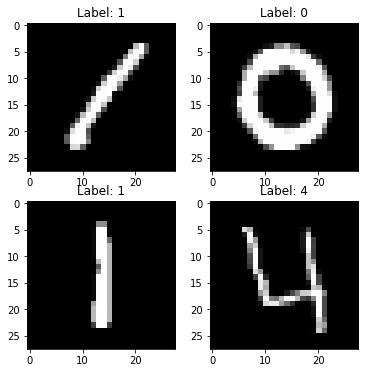

In [8]:
# visualize training dataset
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: {}".format(y_train[i].argmax()))
    plt.imshow(x_train[i].reshape([28,28]),cmap='gray');

In [9]:
# define each layer by producing weights and biases
def define_layer(input_units, output_units):
    
    # we use numpy random normal distrbution to generate weights for each layer
    # and unintinialized numpy array for bias (all zeros)
    w = np.random.normal(loc=0, 
#                         scale = np.sqrt(2/(input_units+output_units)),
                        scale = 0.01, 
                        size = (input_units, output_units))
    b = np.zeros(output_units)
    return w, b

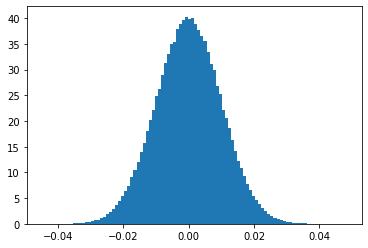

In [10]:
# visualize the weights and biases

# 748 input to 600 output
w1, b1 = define_layer(748, 600)

# flatten the weights for faster processing
wflat = w1.flatten()
plt.hist(wflat, bins=100, density=True)
plt.show()

In [11]:
# define ReLU activation function
def ReLU(x):
    return x * (x > 0)

# define Derivative of ReLU functoion
def dReLU(x):
    return 1. * (x > 0)

# use cross entropy loss function
def cross_ent(y, yhat):
    return -1 * np.sum(y * np.log(yhat))

# define the derivative of cross entropy function
def cross_ent_d(y, yhat):
    return yhat - y

# softmax activation function for one hot encoded
def stable_softmax(x):
    # use stable softmax instead of just softmax
    z = x - np.max(x, axis=-1, keepdims=True)
    numerator = np.exp(z)
    denominator = np.sum(numerator, axis=-1, keepdims=True)
    softmax = numerator / denominator
    return softmax

# linear functio input, weights and biases
def lin_func(a, w, b):
    # we will dot multiplication to multiply arrays
    return np.dot(a, w) + b

In [12]:
# build the model wieghts and biases
w1, b1 = define_layer(784, 600)
w2, b2 = define_layer(600, 450)
w3, b3 = define_layer(450, 320)
w4, b4 = define_layer(320, 100)
w5, b5 = define_layer(100, 10)

# initialize cost list, we'll append cost of the loss function here
costlist = []

# define iterations and learning rate (lr)
iterations = 25
lr = 0.001

In [13]:
# iterate for 30 times
for i in range(iterations):
    # initialize c as the cost
    c = 0
    for o in tqdm(range(len(x_train))):
        
        # forward pass using linear function and
        # ReLU as activation function
        # and Stable Softmax at the end of the layer
        
        InputData1 = x_train[o].reshape(1, 784)
        TargetData1 = y_train[o].reshape(1, 10)
        
        z1 = lin_func(InputData1, w1, b1)
        a1 = ReLU(z1)

        z2 = lin_func(a1, w2, b2)
        a2 = ReLU(z2)

        z3 = lin_func(a2, w3, b3)
        a3 = ReLU(z3)

        z4 = lin_func(a3, w4, b4)
        a4 = ReLU(z4)

        z5 = lin_func(a4, w5, b5)

        a5 = stable_softmax(z5)

        # get the sum of all cost
        c += cross_ent(TargetData1, a5)
        
        # Start Backpropagation
        # get the derivative of cross entropy
        dw5 = cross_ent_d(TargetData1, a5)

        db5 = np.sum(dw5, axis=0, keepdims=True)
        w5 = w5 - lr * np.dot(a4.T, dw5)
        b5 = b5 - lr * db5

        dw4 = np.dot(dw5, w5.T) * dReLU(z4)
        db4 = np.sum(dw4, axis=0, keepdims=True)
        w4 = w4 - lr * np.dot(a3.T, dw4)
        b4 = b4 - lr * db4

        dw3 = np.dot(dw4, w4.T) * dReLU(z3)
        db3 = np.sum(dw3, axis=0, keepdims=True)
        w3 = w3 - lr * np.dot(dz3dw3.T, dw3)
        b3 = b3 - lr * db3

        dw2 = np.dot(dw3, w3.T) * dReLU(z2)
        db2 = np.sum(dw2, axis=0, keepdims=True)
        w2 = w2 - lr * np.dot(a1.T, dw2)
        b2 = b2 - lr * db2

        dw1 = np.dot(dw2, w2.T) * dReLU(z1)
        db1 = np.sum(dw1, axis=0, keepdims=True)
        w1 = w1 - lr * np.dot(InputData1.T, dw1)
        b1 = b1 - lr * db1

    costlist.append(c)

100%|███████████████████████████████████████████████████████████████████████████| 41000/41000 [05:10<00:00, 132.09it/s]


In [ ]:
test_ds = pd.read_csv("./mnist-dataset/test.csv")
x_test = test_ds.values
x_test.shape

274.0552638902669
[16581.418620270193, 5046.218408286645, 3325.7506948316063, 2503.7561007868144, 2063.8715808871234, 1730.6840480147655, 1440.2936287492423, 1085.2965310487984, 977.5322256777829, 814.5686349241842, 823.1484030403957, 799.1985784543189, 658.365526843545, 490.8863702040673, 519.1663075200184, 377.08370058099615, 501.92486468571065, 436.3585547079751, 265.5753250950599, 203.4284683354489, 358.7645394144702, 382.1653842744879, 256.54477552790996, 203.1892732473872, 274.0552638902669]


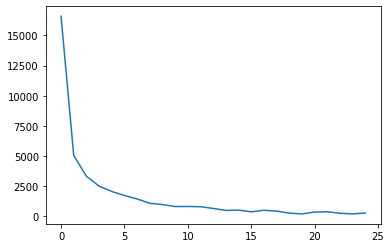

In [14]:
# Visualize the cost list and check the accuracy

print(costlist[-1])
print(costlist)
plt.plot(costlist)
plt.show()

In [44]:
# Validate using validation dataset
# random = np.random.choice(len(x_val))
val_count = 0
for idx in tqdm(range(len(x_val))):
    InputData1 = x_val[idx].reshape(1, 784)
    TargetData1 = y_val[idx].reshape(1, 10)

    z1 = np.dot(InputData1, w1) + b1
    a1 = ReLU(z1)

    z2 = np.dot(a1, w2) + b2
    a2 = ReLU(z2)

    z3 = np.dot(a2, w3) + b3
    a3 = ReLU(z3)

    z4 = np.dot(a3, w4) + b4
    a4 = ReLU(z4)

    z5 = np.dot(a4, w5) + b5
    a5 = stable_softmax(z5)
    
    if abs(np.argmax(a5)-TargetData1.argmax()) == 0:
        val_count += 1
print("Validation Accuracy: {:.2%}".format(val_count/len(x_val)))
# print("The PREDICTED hand written number is", np.argmax(a5))
# print("The TARGET hand written number is", TargetData1.argmax())
# plt.imshow(InputData1.reshape(28, 28))
# plt.show()

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2570.16it/s]

Validation Accuracy: 97.80%
